In [1]:
from recognition_facenet.recognition import face_encodings,model,_detectSingleFace,pnet_fun,rnet_fun,onet_fun
import cv2
import numpy as np
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
import os
from facenet.align.detect_face import detect_face,create_mtcnn
from common import ROC_AUC,plotROC
%matplotlib inline

/home/zhangxk/mysite/facenet/align
load model from /home/zhangxk/mysite/recognition_facenet/model

Instructions for updating:
To construct input pipelines, use the `tf.data` module.



Model directory: /home/zhangxk/mysite/recognition_facenet/model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275


In [2]:
dbFile='/home/zhangxk/mysite/webapp/facedb1'
dbs=[]
for f in os.listdir(dbFile):
#     face=_detectSingleFace(os.path.join(dbFile,f))
    face_encode=face_encodings(os.path.join(dbFile,f))[0]
    dbs.append(face_encode)
dbs=np.array(dbs)

In [3]:
def readDetectFile(fs='webapp/detect/'):
    '''
    read files under fs,return a list of images[HxWxC]
    '''
    images=[]
    for f in os.listdir(fs):
        images.append(imread(os.path.join(fs,f),mode='RGB'))
    return images
def alignImage(images,minsize=50, threshold = [0.6, 0.7, 0.7], factor=0.709,pad=0,image_size=160,savePath=None):
    '''
        images is a list of images,I want to find the face of each image using MTCNN
        return a align verson of images,some face may fail to detect,so len(ret)<=len(images)
    '''
    ret=[]
    for i,I in enumerate(images):
        box, point=detect_face(I,minsize,pnet_fun,rnet_fun,onet_fun,threshold,factor)

        if len(box)==0:continue

        h,w=I.shape[0:2]
        x1, y1, x2, y2, acc = box[0]
        x1, y1, x2, y2 = max(x1-pad, 0), max(y1-pad, 0), min(x2+pad, w), min(y2+pad, h)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        cropped=I[y1:y2,x1:x2]
        aligned = imresize(cropped, (image_size, image_size), interp='bilinear')
        if savePath:
            plt.imsave(os.path.join(savePath,str(i)+'.png'),cropped)
            plt.imsave(os.path.join(savePath,str(i)+'_align.png'),aligned)
        ret.append(aligned)
    return ret

detectImages      =readDetectFile()
print('# of faces:',len(detectImages))
align_detectImages=alignImage(detectImages,savePath='webapp/detect_align')
print('# of align faces:',len(align_detectImages))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


# of faces: 252
# of align faces: 250


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


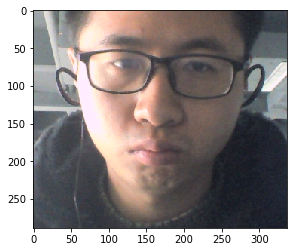

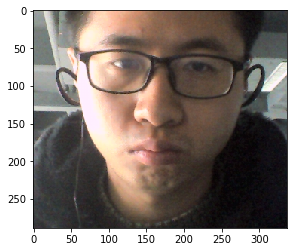

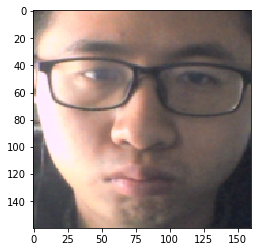

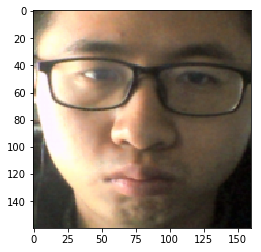

In [21]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#I write this function because I hope auto adjust contract can improve the quality of Image,so I can
#improve my performance
def auto_contract(I):
    ms=MinMaxScaler(feature_range=(0,255))
    oldshape=I.shape
    I.shape=(-1,3)
    Inew=ms.fit_transform(I).astype(np.uint8)
    
    I.shape=oldshape
    Inew.shape=oldshape
    
    return Inew

n=44
I=detectImages[n]
Ia=align_detectImages[n]

plt.figure()
plt.imshow(I)
plt.figure()
plt.imshow(auto_contract(I))
plt.figure()
plt.imshow(Ia)
plt.figure()
plt.imshow(auto_contract(Ia))

In [4]:
def writenface(images): 
    '''
        set mean=0,std=1,do not care about spatial imformation
    '''
    images=np.array(images)
    
    m,h,w,c=images.shape
    images.shape=(m,h*w*c)
    
    u=np.mean(images,axis=1,keepdims=True)
    s=np.std(images,axis=1,keepdims=True)
    images= (images-u)/s
    images.shape=(m,h,w,c)
    return images
writen_faces=writenface(align_detectImages)
#after writen,I compute feature of each face
batch=32
batchcodes=[]
m=len(writen_faces)
steps= int(np.ceil(m/32))
for s in range(steps):
    code=model.predict(writen_faces[s*batch:(s+1)*batch])
    batchcodes.append(code)
batchcodes=np.concatenate(batchcodes,axis=0)

In [5]:
#I want be cool ,so I using this fancy policy to compute disi<Xi,Bj>
def computeSimiliary(s,b):
    '''
        s mxn
        b kxn
        return sb have shape mxk
        sb[i,j]=|si-bj|
    '''
    s,b=s.copy(),b.copy()
    s=np.expand_dims(s,axis=1) #mx1xn
    b=np.expand_dims(b,axis=0) #1xk*n
    sb=np.linalg.norm(s-b,axis=2)
    return sb
MK=computeSimiliary(batchcodes,dbs)

1.471371 0.049749453
0.8186648 0.07691731
1.5604893 0.036184102
1.4308875 0.04446733
1.465172 0.04091243
1.1343043 0.05699803
0.91082275 0.05833793
1.1028833 0.07855173
1.4170948 0.046129912
1.2451226 0.0429859
0.8009234 0.073803924
0.56192607 0.11225159
1.374888 0.04447008
1.0645071 0.04893297
1.2247256 0.05490536
1.0144587 0.058651574


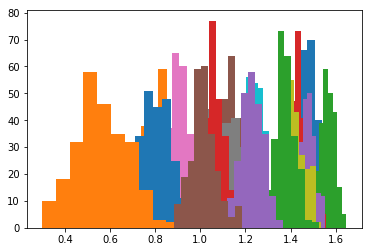

In [6]:
#for zhangxk.png
# u=0.56192607 sigma=0.11225159
# [0.44967447966337204 0.6741776540875435]
for k in range(MK.shape[1]):
    dists=MK[:,k]
    u,s=np.mean(dists),np.std(dists)
    plt.hist(dists)
    print(u,s)
#     print(u-1*s,u+1*s)

best rule is score<=0.702520,under this rule,TPR is 0.892000,FPR is 0.009067


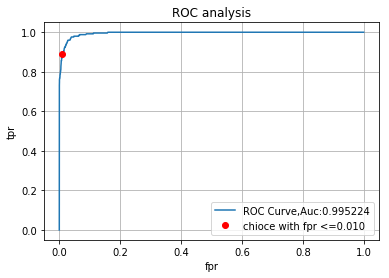

In [18]:
from sklearn.metrics import roc_auc_score,auc
K=11 #I am cheat
y=np.zeros(MK.shape)
y[:,K]=1
y=y.astype(np.bool8)

thresold=np.linspace(0.01,2,1000,endpoint=False)
TPR,FPR=[],[]
for t in thresold:
    yhat=(MK<=t)
    TP=np.sum(y*yhat)
    FP=np.sum((~y)*yhat)
    TN=np.sum((~y)*(~yhat))
    FN=np.sum(y*(~yhat))
    TPR.append((TP)/(TP+FN))
    FPR.append((FP)/(FP+TN))
TPR,FPR=np.array(TPR),np.array(FPR)
plotROC(FPR,TPR,auc(FPR,TPR),thresold,0.01)

# the criteria is if yhat<=t  then y=1 for ROC_AUC rule,and also is my policy
#something wrong with it
# fp,tp,thresolds,auc=ROC_AUC(y.ravel(),yhat.ravel(),flag='binary')
# plotROC(fp,tp,auc,thresolds,.1)



### I will show that the jagged result between same person,My goal is to reduce mean and stand diveratoin!

sample size is : 31125
true answer is , 31125.0
0.60630655 0.12857589
0.4777306616306305 0.7348824441432953


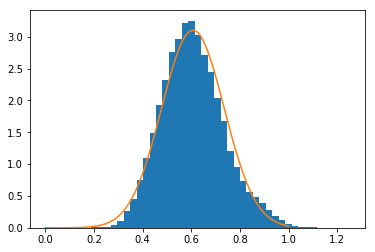

In [17]:

D=batchcodes.dot(batchcodes.T)
A=np.diag(D)
A.shape=(-1,1)
nsquare=A+A.T-2*D
dists=nsquare**(0.5)
# dists[i,j] is distance between xi,xj,so I only want upper triangle part
dists=np.triu(dists,1)
dists=dists[dists>0]
print('sample size is :',len(dists))
print('true answer is ,',(m*m-m)/2)
plt.hist(dists,40,normed=True)
u,s=np.mean(dists),np.std(dists)
# sample size is : 31125
# true answer is , 31125.0
# 0.60630655 0.12857589
# 0.4777306616306305 0.7348824441432953
print(u,s)
print(u-1*s,u+1*s)

def pdf(x,u,sigma):
    return np.exp(-((x-u)**2) /(2*sigma*sigma))/(np.sqrt(2*np.pi)*sigma)
x=np.linspace(0,1,1000)
y=pdf(x,u,s)
plt.plot(x,y)